# __Step 6.1: Arabodopsis-related topic over time__

Goals here:
- Model topics for docs mentioning Arabidopsis
- Model Arabidopsis topics over time

Issues:
- 10/4/22: 
  - Run BERTopic and get `RuntimeError: CUDA error: no kernel image is available for execution on the device`.
    - Reinstall torch following advices from [here](https://github.com/NVlabs/stylegan2-ada-pytorch/issues/6) for example
    - `conda install pytorch torchvision torchaudio cudatoolkit=11.6 -c pytorch -c conda-forge`
  - Once updating torch, run into problem that numba requires numpy <=1.21
    - `conda install numpy=1.21`
  - Get `AttributeError: 'BERTopic' object has no attribute 'generate_topic_labels'`
    - Update BERTopic: `pip install --upgrade bertopic`
  - Get `ImportError: cannot import name 'DatasetInfo' from 'huggingface_hub.hf_api'`
    - Update huggingface_hub
  - Because BERTopic is updated, the c-tf-idf matrix name is changed. This is not changed for earlier codes.

## ___Set up___

### Module import

In bertopic environment

In [1]:
import re, pickle, os, torch, csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
from xlsxwriter.workbook import Workbook
from datetime import datetime
from bisect import bisect
from sklearn.preprocessing import normalize
import plotly.graph_objects as go

In [2]:
torch.cuda.is_available, torch.__version__

(<function torch.cuda.is_available() -> bool>, '1.12.1')

### Key variables

In [3]:
# Reproducibility
seed = 20220609

# Setting working directory
proj_dir   = Path.home() / "projects/plant_sci_hist"
work_dir   = proj_dir / "6_topic_model_arabidopsis/"
work_dir.mkdir(parents=True, exist_ok=True)

# plant science corpus with date and other info
dir2        = proj_dir / "2_text_classify//2_5_predict_pubmed"
corpus_file = dir2 / "corpus_plant_421658.tsv.gz"

# Species match data
dir5               = proj_dir / "5_species_over_time/"
viridi_offspr_file = dir5 / "viridiplantae_offspring_names.pickle" 
match_csr_file     = dir5 / "match_csr.pickle"

# BERT model to use
model_name     = "allenai/scibert_scivocab_uncased"
model_name_mod = "-".join(model_name.split("/"))

# the target term
target = "Arabidopsis"

## outputs for topic modeling
# path for the corpus for the target (i.e., Arabidopsis)
corpus_target_file = work_dir / "corpus_arabidopsis.tsv.gz"
# generated during bertopic run
docs_clean_file  = work_dir / f"docs_clean_{target}.pickle"
emb_file         = work_dir / f"embeddings_{target}_scibert.pickle"
topic_model_file = work_dir / f"topic_model_{target}_{model_name_mod}"
topics_file      = work_dir / f"topics_{target}_{model_name_mod}.pickle"
probs_file       = work_dir / f'probs_{target}_{model_name_mod}.pickle'
topic_model_updated_file = work_dir / \
                              f"topic_model_update_{target}_{model_name_mod}"

## outputs for topic model analysis
top_50_terms_file = work_dir / f'top_50_terms_per_topic_{target}.pickle'
top_50_terms_xlsx = work_dir / f'top_50_terms_per_topic_{target}.xlsx'
topic_label_file  = work_dir / f"topic_labels_{target}.txt"
rep_docs_file     = work_dir / f"topic_rep_docs_{target}.tsv"

# Put the top 50 term info into different tsv files in the top_50 folder
top_50_dir = work_dir / "top_50"
top_50_dir.mkdir(parents=True, exist_ok=True)

## output for topic over time analysis
# Creat a folder to store c-tf-idf matrix for each timestamp bin
ctfidf_dir = work_dir / "ctfidf_over_time"
ctfidf_dir.mkdir(parents=True, exist_ok=True)

# Create a folder to store topic over time graph for each topic
tot_graph_dir = work_dir / 'tot_graphs'
tot_graph_dir.mkdir(parents=True, exist_ok=True)

# So PDF is saved in a format properly
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "sans-serif"

## ___Get all Arabidopsis records___

### Get match_csr column that is for Arabidopsis

In [4]:
# load the saved csr
with open(match_csr_file, "rb") as f:
  match_csr = pickle.load(f)

# load viridiplantae offspring names that is the same order as match_csr
with open(viridi_offspr_file, "rb") as f:
  viridi_offspr_names = pickle.load(f)

In [5]:
# Check dimension
match_csr.shape, len(viridi_offspr_names)

((421658, 26782), 26782)

In [6]:
target_idx = viridi_offspr_names.index(target)
target_idx

22612

In [7]:
# Get indicues of non-zero elements
#https://numpy.org/doc/stable/reference/generated/numpy.nonzero.html
target_match_arr = match_csr[:,target_idx].toarray().ravel()
target_match_idx = np.nonzero(target_match_arr)[0]

# Check datatype, shape, and total (ok)
type(target_match_arr), len(target_match_arr), np.sum(target_match_arr)

(numpy.ndarray, 421658, 50346)

In [8]:
len(target_match_idx), target_match_idx[:5]

(50346, array([ 994, 1725, 2524, 3022, 3032]))

### Get the corpus dataframe for records mentioning Arabidopsis

In [9]:
# Read corpus file
corpus_all = pd.read_csv(corpus_file, compression='gzip', sep='\t')

In [10]:
# Make sure the corpus contain Arabidopsis, test the 1st 1000
#https://www.statology.org/pandas-select-rows-by-index/
test1000     = corpus_all.loc[target_match_idx[:1000]]['txt']
count_found = 0
for txt in test1000:
  if "Arabidopsis" in txt:
    count_found += 1

print(count_found)

1000


In [11]:
# Get the dataframe for Arabidopsis
if corpus_target_file.is_file():
  print("  load corpus_target_file")
  corpus_target = pd.read_csv(corpus_target_file, sep='\t', compression='gzip')
else:
  print("  generate corpus_target_file")
  corpus_target = corpus_all.loc[target_match_idx]
  corpus_target.to_csv(corpus_target_file, sep='\t', compression='gzip')
  
print(corpus_target.shape)

  load corpus_target_file
(50346, 12)


## ___Topic modeling___

Codes modified from `script_4_1_topic_model_v2.py` and `script_4_2_outlier_assign.ipynb`

### Pre-processing texts

In [12]:
def clean_text(x, stop_words_dict):
    x = str(x)
    x = x.lower()
    # Replace any non-alphanumric characters of any length
    # Q: Not sure what the # character do.
    x = re.sub(r'#[A-Za-z0-9]*', ' ', x)
    # tokenize and rid of any token matching stop words
    tokens = word_tokenize(x)
    x = ' '.join([w for w in tokens if not w in stop_words_dict])
    return x
    
print("Pre-processing docs")
if docs_clean_file.is_file():
  print("  load processed docs")
  with open(docs_clean_file, "rb") as f:
    docs_clean = pickle.load(f)
else:
  print("  read corpus and process docs")
  corpus_target_df = pd.read_csv(corpus_target_file, sep='\t', compression='gzip')
  
  docs       = corpus_target_df['txt']
  stop_words = stopwords.words('english')
  stop_words_dict = {}
  for i in stop_words:
    stop_words_dict[i] = 1

  docs_clean = []
  for doc_idx in tqdm(range(len(docs))):
    doc = docs[doc_idx]
    docs_clean.append(clean_text(doc, stop_words_dict))
  with open(docs_clean_file, "wb") as f:
    pickle.dump(docs_clean, f)

len(docs_clean)

Pre-processing docs
  load processed docs


50346

### Generate embeddings

In [13]:
# Generate embeddings
if emb_file.is_file():
  print("Load embeddings")
  with open(emb_file, "rb") as f:
    embeddings = pickle.load(f)
else:
  print("Generate embeddings")
  emb_model  = SentenceTransformer(model_name)
  embeddings = emb_model.encode(docs_clean, show_progress_bar=True)
  # Output embeddings
  with open(emb_file, "wb") as f:
    pickle.dump(embeddings, f)

Load embeddings


### Run BERTopic

#### Set parameters

In [14]:
# HDBSCAN clustering setting
min_cluster_size         = 100 # This is 500 for the full dataset run
metric                   = 'euclidean' 
cluster_selection_method ='eom' 
prediction_data          = True 
min_samples              = 5

# BERTopic setting
calculate_probabilities = True
n_neighbors             = 10  
nr_topics               = 500
n_gram_range            = (1,2)

#### Initialize HDBSCAN

For reducing outliers, following [this instruction](https://maartengr.github.io/BERTopic/faq.html#how-do-i-reduce-topic-outliers)
- Also see [HDBSCAN doc](https://hdbscan.readthedocs.io/en/latest/basic_hdbscan.html#what-about-different-metrics)
- Comparison of [distance metrics](https://www.kdnuggets.com/2019/01/comparison-text-distance-metrics.html)

In [15]:
hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size, 
                        metric=metric, 
                        cluster_selection_method=cluster_selection_method, 
                        prediction_data=prediction_data, 
                        min_samples=min_samples)

#### Intialize and train topic model

In [16]:
topic_model = BERTopic(hdbscan_model=hdbscan_model,
                       calculate_probabilities=calculate_probabilities,
                       n_gram_range=n_gram_range,
                       nr_topics=nr_topics,
                       verbose=True)

In [17]:
topics, probs = topic_model.fit_transform(docs_clean,
                                          embeddings)

2022-10-10 10:25:59,559 - BERTopic - Reduced dimensionality
2022-10-10 10:26:11,549 - BERTopic - Clustered reduced embeddings
2022-10-10 10:26:52,398 - BERTopic - Reduced number of topics from 64 to 64


#### Save model, topics, and probability

In [18]:
# I already save the embeddings, so won't save it again
topic_model.save(topic_model_file)

with open(topics_file, "wb") as f:
    pickle.dump(topics, f)

with open(probs_file, "wb") as f:
  pickle.dump(probs, f)

#### Load model and probabilities

This is more for running topic modeling on the much larger corpus. Here the targeted corpus is much smaller. But keep this anyway.

In [19]:
# Load topic model
topic_model = BERTopic.load(topic_model_file)

# load prob
with open(probs_file, "rb") as f:
  probs = pickle.load(f)

In [20]:
topic_info = topic_model.get_topic_info()
topic_info.head(), topic_info.tail()

(   Topic  Count                                       Name
 0     -1  22445          -1_arabidopsis_genes_plants_plant
 1      0    130    0_heterotrimeric_gprotein_rop_signaling
 2      1    125       1_signalling_kinases_plant_signaling
 3      2    121  2_ptdins_inositol_phosphatidylinositol_p2
 4      3    299               3_ubiquitin_sumo_e3_proteins,
     Topic  Count                                        Name
 59     58   1318            58_stress_tolerance_drought_salt
 60     59    439  59_circadian_clock_circadian clock_rhythms
 61     60    390      60_flowering_ft_floral_flowering locus
 62     61    247          61_floral_genes_development_flower
 63     62    878                62_meristem_cell_stem_floral)

## ___Outlier assignments___

Modified from `script_4_2_outlier_assign.ipynb`

### Assignments

In [21]:
# 95 precentile probability value as threshold
probability_threshold = np.percentile(probs, 95)
new_topics = [np.argmax(prob) if max(prob) >= probability_threshold else -1 
                                                            for prob in probs]

In [22]:
# Unassigned doc number
n_unassigned = pd.Series(new_topics).value_counts().loc[-1]
n_unassigned/len(new_topics)

0.05807809955110634

### Update topics


In [23]:
# update topic based on new topics
topic_model.update_topics(docs_clean, new_topics)

In [24]:
# Update topic frequencies
documents = pd.DataFrame({"Document": docs_clean, "Topic": new_topics})
topic_model._update_topic_size(documents)
topic_model.save(topic_model_updated_file)

### Get updated topic info

In [25]:
# Load topic model
topic_model = BERTopic.load(topic_model_updated_file)

In [26]:
topic_info = topic_model.get_topic_info()
topic_info[:5]

,Topic,Count,Name
0,-1,2924,-1_arabidopsis_protein_plant_genes
1,0,145,0_heterotrimeric_gprotein_rop_signaling
2,1,336,1_plant_signaling_kinases_signalling
3,2,325,2_1433_ptdins_cam_binding
4,3,443,3_ubiquitin_sumo_proteins_protein


In [27]:
n_total     = np.sum(topic_info['Count'].values)
n_outlier   = topic_info['Count'][0]
n_in_topics = n_total - n_outlier
n_in_topics, n_in_topics/n_total*100

(47422, 94.19219004488937)

## ___Topic model analysis___

### Topic size distribution

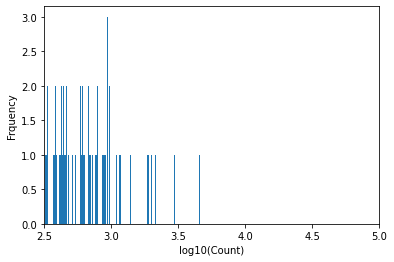

In [28]:
plt.hist(np.log10(topic_info["Count"]), bins=200)
plt.xlabel("log10(Count)")
plt.ylabel("Frquency")
plt.xlim(2.5,5)
plt.savefig(work_dir / f"fig6_topic_count_dist_{target}.pdf")

### Topic-term matrix for top 50 terms

In [29]:
# Sparse matrix with topics as rows and features (i.e. terms) as columns, 
# values are c-Tf-idf
# 10/4/22: The updated BERTopic refer to the c_tf_idf matrix differently with an
#   extra '_' at the end
#topic_term_matrix = topic_model.c_tf_idf
topic_term_matrix = topic_model.c_tf_idf_
type(topic_term_matrix), topic_term_matrix.shape

(scipy.sparse._csr.csr_matrix, (64, 3118232))

In [30]:
# A list of features (terms)
terms = topic_model.vectorizer_model.get_feature_names()

# Get top 50 terms
top_50 = {} # {topic:[top50_idx_list, top50_c-tf-idf_list, to50_feat_list]}

# Skip the outlier topic, named the variable topic_plus1 because the topic
# index is -1 from the index in the topic_term_marix.
for topic_plus1 in tqdm(range(1, topic_term_matrix.shape[0])):
  row     = topic_term_matrix.getrow(topic_plus1).toarray()[0].ravel()

  # The following two lines sorted from low to high
  t50_idx = list(row.argsort()[-50:])
  t50_val = list(row[row.argsort()[-50:]])

  t50_fea = [terms[i] for i in t50_idx]
  top_50[topic_plus1-1] = [t50_idx, t50_val, t50_fea]

100%|██████████| 63/63 [00:10<00:00,  6.22it/s]


In [31]:
# Save the top 50 terms
with open(top_50_terms_file, 'wb') as f:
  pickle.dump(top_50, f)

In [32]:
topic_labels = topic_model.generate_topic_labels(nr_words=10,
                                                 topic_prefix=True,
                                                 separator='|')

In [33]:
# Save top terms for different topics into an xlsx file
xlsx      = Workbook(top_50_terms_xlsx)

# Do not output outlier
topic_label_df = pd.DataFrame(topic_labels[1:])
topic_label_df.columns = ["label"]
topic_label_df.to_csv(topic_label_file, sep='\t')

worksheet = xlsx.add_worksheet("topic_label")
read_tsv = csv.reader(open(topic_label_file,'r',encoding='utf-8'),delimiter='\t')
for row, data in enumerate(read_tsv):
  worksheet.write_row(row, 0, data)

In [34]:
# Incude the representative doc in a worksheet
rep_docs    = topic_model.get_representative_docs()
rep_docs_df = pd.DataFrame.from_dict(rep_docs, orient='index',
                                  columns=['doc1', 'doc2', 'doc3'])
rep_docs_df.to_csv(rep_docs_file, sep='\t')

worksheet = xlsx.add_worksheet("representative docs")
read_tsv = csv.reader(open(rep_docs_file,'r',encoding='utf-8'),delimiter='\t')
for row, data in enumerate(read_tsv):
  worksheet.write_row(row, 0, data)

In [35]:
# Put the top 50 term info into different tsv files in the top_50 folder
# Output individual tsv files and put tsv into xlsx
for topic in top_50:
  topic_file = top_50_dir / f"topic_{topic}.tsv"
  # The nested list has index, c-tf-idf, and feature as rows. So it is transposed
  # to have the rows as columns. The iloc bit is to reverse the order so higher
  # c-tf-idf entries are on top.
  topic_df = pd.DataFrame(top_50[topic]).transpose().iloc[::-1]
  topic_df.columns = ["index", "c-tf-idf", "feature"]
  topic_df.to_csv(topic_file, sep='\t')

  # Save to xlsx
  worksheet = xlsx.add_worksheet(f"{topic}")
  read_tsv  = csv.reader(open(topic_file, 'r',encoding='utf-8'),delimiter='\t')
  for row, data in enumerate(read_tsv):
    worksheet.write_row(row, 0, data)

xlsx.close()

## ___Records per year and timestamp bins___

Code modified from `script_4_4_topic_over_time.ipynb`

### Plot records per year

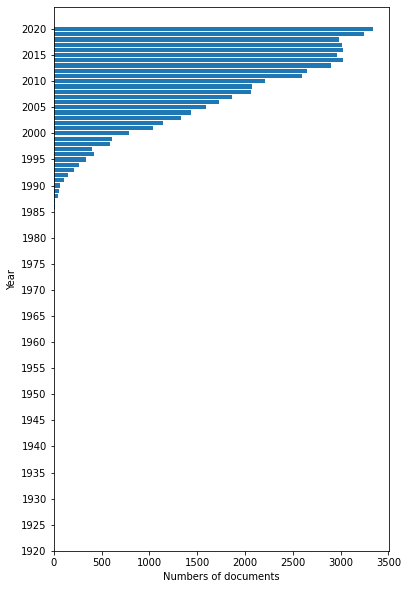

In [36]:
# Get pandas series dates
dates = corpus_target['Date']

ts_for_plot = [] # timestamps for plotting
docs_yr     = [] # a list of years for generating bar graph later
early_doc   = {} # {year: count}
for date in dates:
  [yr, mo, da] = date.split('-') # year, month, day
  # docs from the same year has the same timestamp
  yr = int(yr)
  docs_yr.append(yr)

  # Create 
  if yr not in early_doc:
    early_doc[yr] = 1
  else:
    early_doc[yr]+= 1

  # Set year before 1970 as 1969.
  if yr < 1970:  
    yr = 1969

  # Set year after 2020 as 2020. There are 58 instances
  if yr > 2020:  
    yr = 2020

  dt   = datetime(yr, 1, 1)
  ts   = dt.timestamp()
  ts_for_plot.append(ts)

# array with number of records per year
docs_year_array = np.unique(np.array(docs_yr), return_counts=True)

# dataframe with counts per year
docs_year_df    = pd.DataFrame(docs_year_array[1], columns=["Count"],
                               index=docs_year_array[0])

# without log
plt.figure(figsize=(6,10))
plt.barh(docs_year_array[0], docs_year_array[1])
plt.ylabel('Year')
plt.xlabel('Numbers of documents')
plt.yticks(range(1920, 2021, 5))
plt.savefig(work_dir / f'figure6_num_docs_per_year_{target}.pdf')

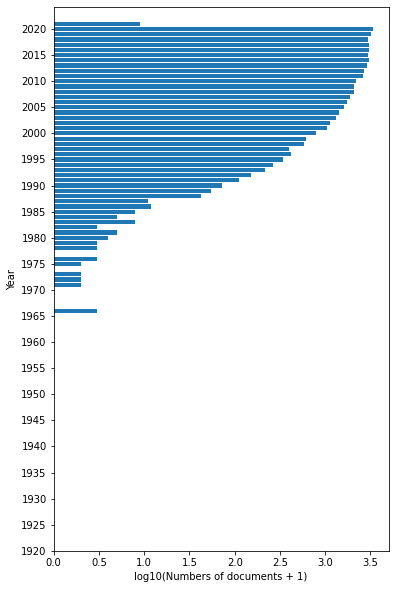

In [37]:
# logged
plt.figure(figsize=(6,10))
plt.barh(docs_year_array[0], np.log10(docs_year_array[1]+1))
plt.ylabel('Year')

# +1 so the x-axis value is not zero.
plt.xlabel('log10(Numbers of documents + 1)')
plt.yticks(range(1920, 2021, 5))
plt.savefig(work_dir / 'figure6_num_docs_per_year_{target}_logged.pdf')

### Get the binned timestamp values

Divide into 20 bins

In [38]:
# Turn all dates into timestamps 
ts_for_bins = []
for date in dates:
  [yr, mo, da] = date.split('-') # year, month, day
  dt   = datetime(int(yr), int(mo), int(da))
  ts   = dt.timestamp()
  ts_for_bins.append(ts)
  
ts_for_bins.sort()

In [39]:
# bin size
bin_num  = 20
bin_size = int(len(ts_for_bins)/bin_num)

# index values of every 1/bin_num*100 percentile (because the data is broken 
# into parts=bin_num)
bin_idxs = [idx for idx in range(0, len(ts_for_bins), bin_size)]

# timestamp values at bin_idxs
bin_timestamps = [ts_for_bins[idx] for idx in bin_idxs]

# Modify the last value to be the max timestamp value + 1. This is otherwise
# because of the bin_size is rounded down the last value be smaller than the max
# timestamp values. Also, +1 to the max value, otherwise, the last entries will
# be in its own bin.
max_timestamp      = max(ts_for_bins) + 1
bin_timestamps[-1] = max_timestamp

# dates correspond to the different timestamp
bin_dates      = [datetime.fromtimestamp(ts) for ts in bin_timestamps]

# Put idx, timestamp, and date into a dataframe and save it.
bin_df         = pd.DataFrame(list(zip(bin_idxs, bin_timestamps, bin_dates)),
            columns=['bin_start_idx', 'bin_start_timestamp', 'bin_start_date'])
bin_df.to_csv(work_dir / f"table6_bin_timestamp_date_{target}.tsv", sep='\t')

In [40]:
bin_df.head(), bin_df.tail()

(   bin_start_idx  bin_start_timestamp bin_start_date
 0              0        -1.211148e+08     1966-03-01
 1           2517         9.030672e+08     1998-08-14
 2           5034         1.006405e+09     2001-11-22
 3           7551         1.071551e+09     2003-12-16
 4          10068         1.124942e+09     2005-08-25,
     bin_start_idx  bin_start_timestamp      bin_start_date
 16          40272         1.509509e+09 2017-11-01 00:00:00
 17          42789         1.536034e+09 2018-09-04 00:00:00
 18          45306         1.561176e+09 2019-06-22 00:00:00
 19          47823         1.585714e+09 2020-04-01 00:00:00
 20          50340         1.609477e+09 2021-01-01 00:00:01)

### Generate the binned timestamps

In [41]:
# Assign new timestamps based on the bin timestamp values
ts_in_bins = []
for date in dates:
  [yr, mo, da] = date.split('-') # year, month, day
  dt   = datetime(int(yr), int(mo), int(da))
  ts   = dt.timestamp()

  bin_idx = bisect(bin_timestamps, ts)

  if bin_idx < len(bin_timestamps):
    ts2     = bin_timestamps[bin_idx]
  # Deal with the last bin
  else:
    ts2     = datetime(2022, 12, 31).timestamp()
  ts_in_bins.append(ts2) 

len(ts_in_bins) # Expect 50346, the number of Arabidopsis docs

50346

## ___Run topics_over_time___

### Set up

In [42]:
docs = docs_clean
topics           = topics
timestamps       = ts_in_bins
nr_bins          = 20
global_tuning    = 0
evolution_tuning = 1

# Get the global (i.e., based on the whole timef rame) ctfidf values
global_c_tf_idf = normalize(topic_model.c_tf_idf_, axis=1, norm='l1', copy=False)
# Construct a documents dataframe
documents = pd.DataFrame({"Document": docs, "Topic": topics, 
                          "Timestamps": timestamps})

In [43]:
# Get topic names, ordered and then get their indices, 0-based
all_topics = sorted(list(documents.Topic.unique()))
all_topics_indices = {topic: index for index, topic in enumerate(all_topics)}

# 53 topics, index=0 is the outlier
len(all_topics), all_topics[0], type(all_topics_indices), all_topics_indices[-1]

(64, -1, dict, 0)

In [44]:
# Bin values into discrete intervals
ts_bins   = [] # a list of tuples showing the bin range (+/-1 of the unique val)
for ts in timestamps:
  ts_bins.append(pd.Interval(left=ts-1, right=ts+1))

# Add the bin info as a new column in documents df
documents["Bins"] = ts_bins
# Add timestamp column
documents["Timestamps"] = documents.apply(lambda row: row.Bins.left, 1)
documents.head(2)

,Document,Topic,Timestamps,Bins
0,somatic mosaicism plants special reference som...,5,903067199.0,"(903067199.0, 903067201.0]"
1,[ growth arabidopsis thaliana embryos followin...,-1,903067199.0,"(903067199.0, 903067201.0]"


In [45]:
# Sort documents in chronological order
documents  = documents.sort_values("Timestamps")

# Unique timestamps
ts_unique = documents.Timestamps.unique()
ts_unique

array([9.03067199e+08, 1.00640520e+09, 1.07155080e+09, 1.12494240e+09,
       1.17082440e+09, 1.21203360e+09, 1.25177760e+09, 1.28763360e+09,
       1.31796000e+09, 1.34880480e+09, 1.37653920e+09, 1.40237280e+09,
       1.42941600e+09, 1.45646280e+09, 1.48307400e+09, 1.50950880e+09,
       1.53603360e+09, 1.56117600e+09, 1.58571360e+09, 1.60947720e+09])

### Run modified topics_over_time code

evolution_tuning=1, global_tuning=0

In [46]:
# For each unique timestamp, create topic representations
topics_over_time = []
for index, timestamp in enumerate(tqdm(ts_unique)):
  #print(index, timestamp)
  # Calculate c-TF-IDF representation for a specific timestamp
  selection = documents.loc[documents.Timestamps == timestamp, :]
  
  docs_per_toc = selection.groupby(['Topic'], as_index=False).agg(
                                {'Document': ' '.join, "Timestamps": "count"})
  c_tf_idf, words = topic_model._c_tf_idf(docs_per_toc, fit=False)
  
  if global_tuning or evolution_tuning:
    c_tf_idf = normalize(c_tf_idf, axis=1, norm='l1', copy=False)

  # Fine-tune the c-TF-IDF matrix at timestamp t by averaging it with the 
  # c-TF-IDF matrix at timestamp t-1
  if evolution_tuning and index != 0:
    curr_toc         = sorted(list(docs_per_toc.Topic.values))
    overlap_toc      = sorted(list(set(prev_toc).intersection(set(curr_toc))))
    curr_overlap_idx = [curr_toc.index(topic) for topic in overlap_toc]
    prev_overlap_idx = [prev_toc.index(topic) for topic in overlap_toc]

    c_tf_idf.tolil()[curr_overlap_idx] = \
      ((c_tf_idf[curr_overlap_idx] + prev_c_tf_idf[prev_overlap_idx]) / 2.0).tolil()

  # Fine-tune the timestamp c-TF-IDF representation based on the global c-TF-IDF representation
  # by simply taking the average of the two
  #if global_tuning:
  #  selected_topics = [all_topics_indices[topic] \
  #                                      for topic in docs_per_toc.Topic.values]
  #  c_tf_idf = (global_c_tf_idf[selected_topics] + c_tf_idf) / 2.0

  # Extract the words per topic
  labels = sorted(list(docs_per_toc.Topic.unique()))
  words_per_toc = topic_model._extract_words_per_topic(words, c_tf_idf, labels)
  topic_frequency = pd.Series(docs_per_toc.Timestamps.values,
                                index=docs_per_toc.Topic).to_dict()
  # Fill dataframe with results
  topics_at_timestamp = [(topic,
                          ", ".join([words[0] for words in values][:5]),
                          topic_frequency[topic],
                          timestamp) for topic, values in words_per_toc.items()]
  topics_over_time.extend(topics_at_timestamp)

  if evolution_tuning:
    prev_toc = sorted(list(docs_per_toc.Topic.values))
    prev_c_tf_idf = c_tf_idf.copy()

  # Save the word list if this is the 1st timestamp
  if index == 0:
    word_file = ctfidf_dir / f"word_list_{len(words)}.pickle"
    with open(word_file, 'wb') as f:
      pickle.dump(words, f)

  # Save the ctfidf values
  ctfidf_file = ctfidf_dir / f'ctfidf_{index}_no_globatune.pickle'
  with open(ctfidf_file, "wb") as f:
    pickle.dump(c_tf_idf, f)

  # Save index and topic name for cross-referencing in ctfidf_file
  toc_index_file = ctfidf_dir / f"ctfidf_{index}_toc_index.tsv"
  docs_per_toc['Topic'].to_csv(toc_index_file, sep='\t')


100%|██████████| 20/20 [06:56<00:00, 20.83s/it]


In [47]:
topics_over_time = pd.DataFrame(topics_over_time, 
                          columns=["Topic", "Words", "Frequency", "Timestamp"])
tot_df_file = work_dir / \
                      f"table6_topics_over_time_df_no_global_tune_{target}.tsv"
topics_over_time.to_csv(tot_df_file, sep='\t')
topics_over_time

,Topic,Words,Frequency,Timestamp
0,-1,"arabidopsis, gene, protein, thaliana, cdna",1088,9.030672e+08
1,0,"7tm, 7tm receptors, heterotrimeric, small prot...",2,9.030672e+08
2,2,"pldgamma, pld, pldalpha, pldbeta, nad kinase",7,9.030672e+08
3,3,"ubiquitin, cop9, e2s, e2, multiubiquitin",13,9.030672e+08
4,4,"uvb, 64, photolyase, uvh1, uvh6",12,9.030672e+08
...,...,...,...,...
1256,58,"drought, stress, tolerance, salt, aba",124,1.609477e+09
1257,59,"clock, circadian, circadian clock, elf4, tempe...",17,1.609477e+09
1258,60,"flowering, vernalization, flowering time, time...",13,1.609477e+09
1259,61,"stamen, tfple, rootlets, mawuap1, doag2",9,1.609477e+09


### Topic over time plot

Customize [BERTopic/bertopic/plotting/_topics_over_time.py](https://github.com/MaartenGr/BERTopic/blob/master/bertopic/plotting/_topics_over_time.py):
- BERTopic version is 0.12.0, different from what I started with 0.9.4.
- The function to modify is `visualize_topics_over_time`.

In [ ]:
def visualize_tot_mod(topic_model, topics_over_time, topics=None, 
                      normalize_frequency=False, width=1000, height=400):

  colors = ["#56B4E9", "#E69F00", "#009E73", "#F0E442", "#D55E00", "#0072B2", 
            "#CC79A7"]

  # Select topics
  if topics:
    selected_topics = topics
  else:
    selected_topics = topic_model.get_topic_freq().Topic.values

  # Prepare data
  # topic_model.topic_names is now topic_model.topic_labels_
  topic_names = {key: value[:40] + "..." if len(value) > 40 else value
                       for key, value in topic_model.topic_labels_.items()}


  topics_over_time["Name"] = topics_over_time.Topic.map(topic_names)
  data = topics_over_time.loc[
    topics_over_time.Topic.isin(selected_topics), :].sort_values(
        ["Topic", "Timestamp"])
    
  # Add traces
  fig = go.Figure()
  max_freq = 0  # set max frequency for plotting purpose
  for index, topic in enumerate(data.Topic.unique()):
    trace_data = data.loc[data.Topic == topic, :]
    topic_name = trace_data.Name.values[0]
    words = trace_data.Words.values
    if normalize_frequency:
      y = normalize(trace_data.Frequency.values.reshape(1, -1))[0]
    else:
      y = trace_data.Frequency

    if max(y) > max_freq:
      max_freq = max(y)
    fig.add_trace(go.Scatter(x=trace_data.Timestamp, y=y, mode='lines+markers',
      marker_color=colors[index % 7], hoverinfo="text",
      name=topic_name,
      hovertext=[f'<b>Topic {topic}</b><br>Words: {word}' for word in words]))

  # Set the xaxis values, just use topic=0 
  unique_tss = data.loc[data.Topic == selected_topics[0], :].Timestamp.tolist()
  datetimes  = [datetime.fromtimestamp(ts) for ts in unique_tss]
  ymds       = [f'{dt.year}-{dt.month}-{dt.day}' for dt in datetimes]
  
  # At recent date it becomes too dense, so only show every 2 dates
  skip_after = datetime(2011, 1, 1).timestamp()
  skip_start_idx = bisect(unique_tss, skip_after)
  unique_tss2 = unique_tss[:skip_start_idx] + unique_tss[skip_start_idx::2]
  ymds2       = ymds[:skip_start_idx] + ymds[skip_start_idx::2]

  # Styling of the visualization
  #toc_str    = "-".join([str(toc) for toc in topics])
  toc_str = topic_names[topics[0]]

  fig.update_xaxes(showgrid=True)
  fig.update_yaxes(showgrid=True)
  fig.update_layout(
    yaxis_title="Normalized Frequency" if normalize_frequency else "Frequency",
    title={'text': f"<b>Topic(s): {toc_str}",
           'y': .95,
           'x': 0.40,
           'xanchor': 'center',
           'yanchor': 'top',
           'font': dict(size=22, color="Black")},
    template="simple_white",
    width=width,
    height=height,
    hoverlabel=dict(bgcolor="white", font_size=16, font_family="Rockwell"),
    legend=dict(title="<b>Global Topic Representation"),
    xaxis=dict(tickmode='array', tickvals=unique_tss2, ticktext=ymds2,
               tickangle=-60))

  # Add decade lines
  for decade in range(1980, 2020, 10):
    dt = datetime(decade, 1, 1)
    ts = datetime.timestamp(dt)
    fig.add_shape(type="line", x0=ts, y0=0, x1=ts, y1=max_freq*1.05,
                  line=dict(color="red", width=3, dash='dot'))

  # Save figure
  fig.write_html(tot_graph_dir / f'tot_graph_topic_{toc_str}_no_globaltune.html')
  fig.write_image(tot_graph_dir / f'tot_graph_topic_{toc_str}_no_globaltune.pdf')

  return fig, unique_tss

In [ ]:
# +2 because zero-indexing and the 1st topic is the outlier (-1)
num_topics = np.max(topics_over_time["Topic"]) + 2

# Go through all topics
for topic in tqdm(range(0, num_topics)):
  visualize_tot_mod(topic_model, topics_over_time, topics=[topic])

### Topic over time heatmap

Codes lifted from `script_5_1_species_over_time.ipynb`
- Ordered based on moving average

In [ ]:
def set_bounds_and_xtick(topX):
  # Set heatmap x-axis
  ts_begin = datetime(1971, 1, 1).timestamp()
  boundsX  = np.insert(ts_unique, 0, ts_begin)

  # Set heatmap y-axis
  toc_nooutlier = np.arange(topX) 
  midpointsY = (toc_nooutlier[:-1] + toc_nooutlier[1:]) / 2
  boundsY    = np.concatenate([[2*midpointsY[0]-midpointsY[1]], 
                              midpointsY, 
                              [2*midpointsY[-1]-midpointsY[-2]]])

  # xtick labels
  ts_unique_dts = [datetime.fromtimestamp(ts) for ts in ts_unique]
  ts_unique_dts = [f"{dt.year}-{dt.month}-{dt.day}" for dt in ts_unique_dts]
  xticklabels   = ["1917-1-1"] + ts_unique_dts

  return boundsX, boundsY, xticklabels

In [ ]:
def moving_avg_reorder_and_plot(values, step_size, level_offspr, level_parent, 
                                topX):
  dict_max_val_ts = {} # {1st_timestamp_in_window:{max_value:[taxa]}}

  #print("In moving_avg_reorder_and_plot:", values.shape)
  count = 0
  for taxa in values.index:
    # series for genus
    val_series = values.loc[taxa]
    val_max    = 0 # for setting value maximum
    val_max_ts = 0 # for setting last_timestamp_in_window for value maximum

    # Go through steps
    for idx in range(0, val_series.shape[0], step_size):
      vals     = val_series.iloc[idx:idx+step_size]
      val_mean = np.mean(vals)
      # new max found, set values
      if val_mean > val_max:
        val_max    = val_mean
        val_max_ts = vals.index[0]
      #print(val_max, val_max_ts)
    
    # set values in dict_max_val_ts
    if val_max_ts not in dict_max_val_ts:
      dict_max_val_ts[val_max_ts] = {val_max:[taxa]}
    elif val_max not in dict_max_val_ts[val_max_ts]:
      dict_max_val_ts[val_max_ts][val_max] = [taxa]
    # for topx=100, step_size=2, one val_max is the same
    else:
      print("Same val_max:", val_max_ts, val_max, taxa)
      dict_max_val_ts[val_max_ts][val_max].append(taxa)

  # Get the new yticklabels based on the ordered ts_max_val
  # was doing list(dict_max_val_ts.keys()), but this gives:
  #  TypeError: list indices must be integers or slices, not float
  max_val_ts   = [key for key in dict_max_val_ts.keys()]
  max_val_ts.sort()
  max_val_ts.reverse()
  new_yticks = []
  for ts in max_val_ts:
    #print(ts)
    val_maxs = [key for key in dict_max_val_ts[ts].keys()]
    val_maxs.sort()
    for val_max in val_maxs:
      #print("", val_max, len(dict_max_val_ts[ts][val_max]))
      #print(ts, val_max, dict_max_val_ts[ts][val_max])
      for taxa in dict_max_val_ts[ts][val_max]:
        new_yticks.append(taxa)
  #print(len(new_yticks))

  # Reorder dataframe
  values_reordered = values.reindex(new_yticks)
  #print("after reordering:", values_reordered.shape)

  # set bounts and xticks
  boundsX, boundsY, xticklabels = set_bounds_and_xtick(topX)

  plot_scaled_heatmap(boundsX, boundsY, xticklabels, new_yticks, 
    values_reordered, f"window{step_size}", level_offspr, level_parent, topX)

  return new_yticks, values_reordered
